## CS 6120: Natural Language Processing - Prof. Ahmad Uzair

### Assignment 1: Naive Bayes
### Total Points: 100 points

You will be dealing with movie review data that includes both positive and negative reviews in this assignment. You will use Sentiment Analysis to assess if a given review is positive or negative using the provided dataset.

Therefore, we will make use of Naive Bayes algorithm to perform sentiment analysis on the movie review dataset.

## Importing the Libraries

In [1]:
import numpy as np
import os
import math
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')
import warnings
import pickle
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay 
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
import string


ModuleNotFoundError: No module named 'numpy'

## Reading the data

When reading the data, ensure that the '.csv' file is in the same location where your jupyter notebook is used. This way the files are organized and easy to read using the pandas library. 

In [124]:
## Reading the data and removing columns that are not important. 
df = pd.read_csv("movie_reviews-1.csv", sep = ',', encoding = 'latin-1', usecols = lambda col: col not in ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"])

In [125]:
df.columns

Index(['review', 'sentiment'], dtype='object')

In [126]:
None  # print head of data frame with help of head function

In [127]:
df.head(15)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,"Petter Mattei's ""Love in the Time of Money"" is...",positive
4,"Probably my all-time favorite movie, a story o...",positive
5,I sure would like to see a resurrection of a u...,positive
6,If you like original gut wrenching laughter yo...,positive
7,This a fantastic movie of three prisoners who ...,positive
8,Some films just simply should not be remade. T...,positive
9,"I remember this film,it was the first film i h...",positive


## Count plot of the output categories: positive or negative

Feel free to take a look at the output and whether the classes are balanced or imbalanced. 

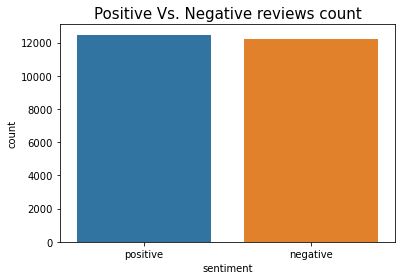

In [128]:
plt.figure(figsize = None)
sns.countplot(x ='sentiment',data=df)
plt.title("Positive Vs. Negative reviews count", fontsize = 15)
plt.show()


## Upsampling the minority class: (5 points)

It is known that Naive bayes is not robust to class imbalance. It could be seen above that the data is little imbalanced. Therefore, class balancing can be done before giving it to the Naive Bayes model for prediction. 

Feel free to use 'resample' library from sklearn. 

In [129]:
## hint: use resample from sklearn.utils
from sklearn.utils import resample

df_majority = df[df["sentiment"] == "positive"]
df_minority = df[df["sentiment"] == "negative"]

negative_upsample = resample(df_minority, replace = True, 
                        n_samples = df_majority.shape[0],
                        random_state = 101)

df_upsampled = pd.concat([df_majority, negative_upsample])  # concat two data frames i,e majority class data set and upsampled minority class data set
df_upsampled = df_upsampled.sample(frac = 1)

In [130]:
## Just to ensure that upsampling was done successfully, take a look at the shape of the data in 
## this cell. 

# print the shape of data set with the help of shape function having "negative" as class label
df_upsampled[df_upsampled["sentiment"] == "negative"].shape

(12474, 2)

### Expected Output : 
(12474, 2)

In [131]:
## Ensure that the same number of data points are present for both 'positive' and 'negative' data

# print the shape of data set with the help of shape function having "positive" as class label
df_upsampled[df_upsampled["sentiment"] == "positive"].shape

(12474, 2)

### Expected Output : 
(12474, 2)

In [132]:
## In this cell, we are going to be dividing the data into train and test points
## Ensure that you store the upsampled data in a variable called 'df_upsampled' 
## so that the below operations are performed successfully


## Considering 10000 positive and 10000 negative data points
negative_data_points_train = df_upsampled[df_upsampled["sentiment"] == "negative"].iloc[:10000]
positive_data_points_train = df_upsampled[df_upsampled["sentiment"] == "positive"].iloc[:10000]

## Considering the remaining data points for test
negative_data_points_test = df_upsampled[df_upsampled["sentiment"] == "negative"].iloc[10000:]
positive_data_points_test = df_upsampled[df_upsampled["sentiment"] == "positive"].iloc[10000:]

## Concatenate the training positive and negative reviews
X_train = pd.concat([positive_data_points_train["review"], negative_data_points_train["review"]])
## Concatenating the training positive and negative outputs
y_train = pd.concat([positive_data_points_train["sentiment"], negative_data_points_train["sentiment"]])

## Concatenating the test positive and negative reviews
X_test = pd.concat([positive_data_points_test["review"], negative_data_points_test["review"]])
## Concatenating the test positive and negative outputs
y_test = pd.concat([positive_data_points_test["sentiment"], negative_data_points_test["sentiment"]])


In [133]:
## Take a look at the total number of classes and their count using '.value_counts()' for y_train and y_test.
## Ensure that there are equal number of positive and negative reviews. 
y_train.value_counts()

positive    10000
negative    10000
Name: sentiment, dtype: int64

### Expected Output:
negative    10000<br>
positive    10000<br>
Name: sentiment, dtype: int64

In [134]:
y_test.value_counts()

positive    2474
negative    2474
Name: sentiment, dtype: int64

### Expected Output : 
negative    2474<br>
positive    2474<br>
Name: sentiment, dtype: int64

## Q1. Pre-process the reviews: (10 points)

We know that a review contains links, punctuation, stopwords and many other words that don't give a lot of meaning for the Naive Bayes model for prediction. 

In the cell below, one must implement text-preprocessing and remove links, punctuations and stopwords. It is also important to lowercase the letters so that 'Admire' and 'admire' are not treated as different words. 

In addition to this, perform stemming operation so that similar words are reduced. To know more about stemming, feel free to take a look at this link.

https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html

In [135]:
# TASK CELL

def clean_review(review):
    review_woStopWords = []
    lemm_review = []
    
    #Removing URLs
    review = re.sub(r"http\S+", "", review)
    
    #storing the puntuation free text
    for i in review:
        if i in string.punctuation:
            review = review.replace(i, "")
    
    #Converting text to lowercase
    review = review.lower()
    
    #Tokenizing
    review = re.split(r'\W+',review)
    
    #Stopwords
    for i in review:
        if i not in stopwords.words('english'):
            review_woStopWords.append(i)
            
    #Stemming
    #porter_stemmer = PorterStemmer()
    #stem_review = [porter_stemmer.stem(word) for word in review_woStopWords]
    
    #Lemmatization
    wordnet_lemmatizer = WordNetLemmatizer()
    lemm_review = [wordnet_lemmatizer.lemmatize(i) for i in review_woStopWords]
    
    #print(lemm_review)
    
    return " ".join(lemm_review)

## Q2. Implement a find_occurrence function (5 points):

In this function, we find the total occurrence of a word giving information such as label, word and frequency dictionary.

Note that this function is used later in the code when we are going to be predicting the output using Naive Bayes. 

In [139]:
# TASK CELL
def find_occurrence(frequency, word, label):
    '''
    Params:
        frequency: a dictionary with the frequency of each pair (or tuple)
        word: the word to look up
        label: the label corresponding to the word
    Return:
        n: the number of times the word with its corresponding label appears.
    '''
    #n =0
    
    if (word, label) in frequency:
        n = frequency[(word, label)]
    else: 
        n =0
  
    return n

### Converting output to numerical format:

We have outputs as 'positive' or 'negative'. In the cell below, we convert it to a numerical format. 

In [141]:
## With the use of mapping function, we replace
## the label in the form of string to an integer. 

output_map = {'positive': 0, 'negative': 1}
y_train = y_train.map(output_map)
y_test = y_test.map(output_map)

In [142]:
## Ensuring that there are equal number of classes on the training data. 
y_train.value_counts()

0    10000
1    10000
Name: sentiment, dtype: int64

In [143]:
## Choosing a random review and taking a look at it.
X_train.iloc[0]

'A fine Martino outing, this is a spirited and enjoyable giallo with fine performances from good looking cast and principally the two leads, George Hilton and Anita Strindberg.<br /><br />For me the jig-saw puzzle of a plot is so convoluted and confusing you just sit back and enjoy rather than try to anticipate. Just when all seems resolved we are again taken on a further series of twists, enjoyable twists, it has to be said.<br /><br />Sexy with plenty of gory kills this a well paced movie with London, Athens and Greek coastal locations. A super finale set upon Aegean rocks wraps things up and much fun was had by all.'

From the above cell output, it could be seen that there are a lot of words that don't add a lot of meaning to the text. 

Therefore, those words would be removed. It also reduces the computation time. 

Therefore, it is a good practice we are following.

In [144]:
custom_review = X_train.iloc[0]

# print cleaned review
print(clean_review(custom_review))

fine martino outing spirited enjoyable giallo fine performance good looking cast principally two lead george hilton anita strindbergbr br jigsaw puzzle plot convoluted confusing sit back enjoy rather try anticipate seems resolved taken series twist enjoyable twist saidbr br sexy plenty gory kill well paced movie london athens greek coastal location super finale set upon aegean rock wrap thing much fun


We now use this function to pre-process the review and remove words that don't add a lot of meaning in our model. 

## Q3. Implementing review counter function: (5 points)

It is now time to implement the count function for the reviews. 

In this function, we count the occurrence of words and get the probabilities 
for the words based on the training data. 

In other words, we get the probability of occurrence of a word, given that the output is 'positive'.

Similarly, we also compute the probability of occurence of a word, given that the output is 'negative'.



In [145]:
# TASK CELL
def review_counter(output_occurrence, reviews, positive_or_negative):
    '''
    Params:
        output_occurrence: a dictionary that will be used to map each pair to its frequency
        reviews: a list of reviews
        positive_or_negative: a list corresponding to the sentiment of each review (either 0 or 1)
    Return:
        output: a dictionary mapping each pair to its frequency
    '''
    ## Steps :
    # define the key, which is the word and label tuple
    # if the key exists in the dictionary, increment the count
    # else, if the key is new, add it to the dictionary and set the count to 1
    
    for label, review in zip(positive_or_negative, reviews):
        split_review = clean_review(review).split()
        
        for word in split_review:
            key = (word, label)
            #print(key)
            
            if key in output_occurrence:
                output_occurrence[key] +=1
            else:
                output_occurrence[key]=1
        
    return output_occurrence
   


### Test your function with example reviews:

Feel free to run the cell below and understand whether the above function that you have defined is producing the optimum results. 

In [146]:
# Testing your function

result = {}
reviews = ['got bored throught the moview', 'The movie was fantastic', 'Will not watch it again', 'Was bored, it was a complete waste of time and money', 'Enjoyed the movie to the fullest']
ys = [1, 0, 1, 1, 0]
review_counter(result,reviews, ys)

{('got', 1): 1,
 ('bored', 1): 2,
 ('throught', 1): 1,
 ('moview', 1): 1,
 ('movie', 0): 2,
 ('fantastic', 0): 1,
 ('watch', 1): 1,
 ('complete', 1): 1,
 ('waste', 1): 1,
 ('time', 1): 1,
 ('money', 1): 1,
 ('enjoyed', 0): 1,
 ('fullest', 0): 1}

### Expected Output:
 {('bored', 1): 2, <br>
 ('complete', 1): 1, <br>
 ('enjoyed', 0): 1, <br>
 ('fantastic', 0): 1, <br>
 ('fullest', 0): 1, <br>
 ('got', 1): 1, <br>
 ('money', 1): 1, <br>
 ('movie', 0): 2, <br>
 ('moview', 1): 1, <br>
 ('throught', 1): 1, <br>
 ('time', 1): 1, <br>
 ('waste', 1): 1, <br>
 ('watch', 1): 1}

In [147]:
# Build the freqs dictionary for later uses

freqs = review_counter({}, X_train, y_train)

In [ ]:
## Run this cell to get an idea about the corpus of words and their occurrence along with labels. 
## In this, we are computing the frequency of occurrence of word given that a review is 'positive'.
## Similarly, we also compute the frequence of occurence of word given that a review is 'negative'.
freqs

## Q4. Training the Naive Bayes Model: (20 points)

Now we are in the training phase of the Naive Bayes algorithm. In this cell, take a look at the ways to calculate the log likelihood and log prior values as these are important for testing in the next few cells. 

Also calculate the frequency of occurrence of words where the output is negative. In the same way, calculate the word frequency count using the above functions in order to compute the log likelihood.

Return the logprior and loglikelihood output by the model from this function. 

In [149]:
def train_naive_bayes(freqs, train_x, train_y):
    '''
    Input:
        freqs: dictionary from (word, label) to how often the word appears
        train_x: a list of reviews
        train_y: a list of labels correponding to the reviews (0,1)
    Output:
        logprior: the log prior. (equation 3 above)
        loglikelihood: the log likelihood of you Naive bayes equation. (equation 6 above)
    '''
    loglikelihood = {}
    logprior = 0


    # calculate V, the number of unique words in the vocabulary
    vocab = set([pair[0] for pair in freqs.keys()])
    V = len(vocab)
    #print(vocab)
    #print(V)

    # calculate num_pos and num_neg - the total number of positive and negative words for all documents
    num_pos = num_neg = 0
    #print(frequency_dict)
    #for pair in frequency_dict.keys():
    for pair in freqs.keys():
        # if the label is positive (greater than zero)
        if pair[1] == 0:
            #print(pair)
            # Increment the number of positive words by the count for this (word, label) pair
            num_pos += freqs[pair]

        # else, the label is negative
        else:

            # increment the number of negative words by the count for this (word,label) pair
            num_neg += freqs[pair]

    # Calculate num_doc, the number of documents
    num_doc = len(train_y)

    # Calculate D_pos, the number of positive documents 
    pos_num_docs = sum(train_y == 0 )

    # Calculate D_neg, the number of negative documents 
    neg_num_docs = num_doc - pos_num_docs

    # Calculate logprior
    logprior = np.log(neg_num_docs) - np.log(pos_num_docs)

    # For each word in the vocabulary...
    for word in vocab:
        # get the positive and negative frequency of the word
        freq_pos = find_occurrence(freqs, word, 0)
        freq_neg = find_occurrence(freqs, word, 1)

        # calculate the probability that each word is positive, and negative
        p_w_pos = (freq_pos + 1)/(num_pos + V)
        p_w_neg = (freq_neg + 1)/(num_neg + V)

        # calculate the log likelihood of the word
        loglikelihood[word] = np.log(p_w_neg) - np.log(p_w_pos)


    return logprior, loglikelihood

In [150]:
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything
logprior, loglikelihood = train_naive_bayes(freqs, X_train, y_train)
print(logprior)
print(len(loglikelihood))

0.0
91643


### Expected Output 

0.0 <br>
91425

## Q5. Implementing Naive Bayes Predict Function: (10 points)

It is now time to make our prediction as to whether a given review is negative or positive respectively. 

After adding the log likelihood values, ensure that the output is 1 (negative) if the sum of the log likelihood value is greater than 0 and 0 (positive) if the sum of the log likelihood is less than or equal to 0. 

In [151]:
# TASK 4 CELL

def naive_bayes_predict(review, logprior, loglikelihood):
    '''
    Params:
        review: a string
        logprior: a number
        loglikelihood: a dictionary of words mapping to numbers
    Return:
        total_prob: the sum of all the loglikelihoods of each word in the review (if found in the dictionary) + logprior (a number)

    '''
    
      # process the review to get a list of words
    word_l = clean_review(review).split()

    # initialize probability to zero
    total_prob = 0

    # add the logprior
    total_prob += logprior

    for word in word_l:

        # check if the word exists in the loglikelihood dictionary
        if word in loglikelihood:
            # add the log likelihood of that word to the probability
            total_prob += loglikelihood[word]
            
    if total_prob > 0:
        return 1
    else: 
        return 0

In [152]:
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything

# Experiment with your own review.
my_review = "I thought this series was going to be another fun, action series with some dynamic plots and great performances. I was wrong. While I like Jamie Denton, this show is hardly worth watching at all, unless you enjoy watching some people brutalized and the actions of the agents supposedly warranted under the theme of national security. The show is great propaganda for the current government, and spews out jingoism as though we talk that way every day. After a couple of episodes, it was boring the hell out of me, and I started watching reruns of House Invaders on BBCAmerica instead. Rather watch CSI and Without a Trace, without a doubt."
p = naive_bayes_predict(my_review, logprior, loglikelihood)
print('The expected output is', p)

The expected output is 1


### Expected Output :
The expected output is 1

## Q6. Implementing Naive Bayes Test function: (10 points)

In this function, implement the previous functions such as naive_bayes_predict to get the predictions for the test set. 

In addition to this, the function should return the total number of reviews that it correctly classified as 'positive' or 'negative'. 

In [153]:
# UNQ_C6 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def test_naive_bayes(test_x, test_y, logprior, loglikelihood):
    """
    Input:
        test_x: A list of reviews
        test_y: the corresponding labels for the list of reviews
        logprior: the logprior
        loglikelihood: a dictionary with the loglikelihoods for each word
    Output:
        accuracy: (# of reviews classified correctly)/(total # of reviews)
    """
    accuracy = 0  

    
    y_hats = []
    for review in test_x:
        # if the prediction is > 0
        if naive_bayes_predict(review, logprior, loglikelihood) > 0:
            # the predicted class is 1
            y_hat_i = 1
        else:
            # otherwise the predicted class is 0
            y_hat_i = 0

        # append the predicted class to the list y_hats
        y_hats.append(y_hat_i)

    # error is the average of the absolute values of the differences between y_hats and test_y
    error = sum([abs(x-y) for (x,y) in zip(y_hats,test_y)])/len(test_y)

    accuracy = 1-error

    print(accuracy)
    
    return accuracy, y_hats

In [76]:
accuracy, predictions  = test_naive_bayes(X_test,y_test,logprior, loglikelihood)

0.8827809215844786


In [154]:
# For grading purpose only
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything

# Run this cell to test your function

for review in ["If you like original gut wrenching laughter you will like this movie. If you are young or old then you will love this movie, hell even my mom liked it.<br /><br />Great Camp!!!",
                "What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative direction, too. Some VERY faint echoes of Fargo here, but it just doesn't come off.",
                "I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the romance between Joe and Jean keeps me on the edge of my seat, plus I still think Bryan Brown is the tops. Brilliant Film.",
                "Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement value. About as unentertaining, uninstructive and just plain dull as a film can be."]:
    p = naive_bayes_predict(review, logprior, loglikelihood)
    print(f'{review[:100]} -> {p:.2f}')
    

If you like original gut wrenching laughter you will like this movie. If you are young or old then y -> 0.00
What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative  -> 1.00
I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the -> 0.00
Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement val -> 1.00


### Expected Output :

If you like original gut wrenching laughter you will like this movie. If you are young or old then y -> 0.00 <br>
What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative  -> 1.00<br>
I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the -> 0.00 <br>
Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement val -> 1.00



In [155]:
# Feel free to check the sentiment of your own review below
my_review = 'The moview was very boring, I wanted to leave in the middle'
naive_bayes_predict(my_review, logprior, loglikelihood)

1

### Expected Output :
1

# Q7. Evaluate the accuracy (10 Points)
1. Split your data into training and test sets using random selection. Set the seed as parameter of the function so that user can select a different training and test set by changin seed.

2. Calculate model paramters with training set.

3. Print confusion matrix for training and test set.

4. Examine False Positive and False Negative cases and provide reasoning why they get misclassified.

In [91]:
def random_accuracy_check(df_upsampled, seed):
    
    #df_upsampledA = df_upsampled.sample(frac = seed)
    #df_upsampledA = pd.concat([y_test, predictions])
    df_upsampledA = df_upsampled.sample(frac = 1, random_state = seed)
    
    negative_data_points_train = df_upsampledA[df_upsampledA["sentiment"] == "negative"].iloc[:10000]
    positive_data_points_train = df_upsampledA[df_upsampledA["sentiment"] == "positive"].iloc[:10000]

    ## Considering the remaining data points for test
    negative_data_points_test = df_upsampledA[df_upsampledA["sentiment"] == "negative"].iloc[10000:]
    positive_data_points_test = df_upsampledA[df_upsampledA["sentiment"] == "positive"].iloc[10000:]

    ## Concatenate the training positive and negative reviews
    X_train = pd.concat([positive_data_points_train["review"], negative_data_points_train["review"]])
    ## Concatenating the training positive and negative outputs
    y_train = pd.concat([positive_data_points_train["sentiment"], negative_data_points_train["sentiment"]])

    ## Concatenating the test positive and negative reviews
    X_test = pd.concat([positive_data_points_test["review"], negative_data_points_test["review"]])
    ## Concatenating the test positive and negative outputs
    y_test = pd.concat([positive_data_points_test["sentiment"], negative_data_points_test["sentiment"]])
    
    output_map = {'positive': 0, 'negative': 1}
    y_train = y_train.map(output_map)
    y_test = y_test.map(output_map)
    
    freqs = review_counter({}, X_train, y_train)
    logprior, loglikelihood = train_naive_bayes(freqs, X_train, y_train)
    accuracy, predictions  = test_naive_bayes(X_test,y_test,logprior, loglikelihood)
    print(accuracy)
    
    con_matrix = confusion_matrix(y_test, predictions, labels=[0 , 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=con_matrix, display_labels=["positive", "Negative"])
    disp.plot()
    plt.show()
    
    return

0.8799514955537591
0.8799514955537591


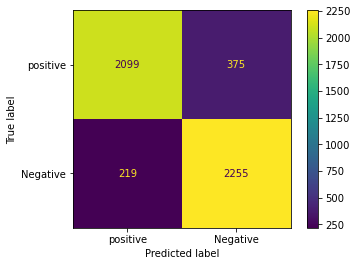

In [92]:
random_accuracy_check(df_upsampled, 2)

# False Negative analysis

Review: Chances are, you'll think this movie is incredibly stupid the first time you watch it. But if, by chance, you watch it a second and third and fourth and fifth time (I'm well into the hundreds by now), you will find yourself spitting a line from it here and there and cracking yourself up! My friends and I have actually thrown Fear of a Black Hat Parties to get more of our friends, "as they say, down with the riots".
Actual classification : Positive
Model classificiation: Negative

Here the review is falsely classified as negative because of the words like stupid and fear as these words have a high positive loglikelihood.

# False Positive analysis

I finally rented this video after searching for it for many months. Initially I only wanted to see it because I'm an out and out Neil Pearson fan (Patrick, boyfriend of Isobel, the lead). However, the movie stands up very well without Neil (although he handles himself very well in this movie, he is overshadowed by the three main female characters). It's an eerie, intense movie, the sort the Brits do so well - definitely a "chick flick" the house and it's isolated setting giving the movie an almost "Wuthering Heights" aura. The movie is full of tension and the ending, shocking, yet somehow inevitable. I'm glad I watched it, it was worth the wait

Actual classification: Negative
Model Classification: Positive

Here the review is falsely classified as positive because of the words such as intense, aura as these words have a high negative loglikelihood.

# Reason

We see that a review is falsely classified as positive or negative because Naive bayes works on the concept of "Bag of words", it does not consider the overall sentiment of the sentence but just words. Hence, if in a positive review there are words that have a high loglikelihood then the entire review will be classified as negative

# Q8. Modularize your calssifier (10 points)
1. Convert your code into a python module text_classifier.py

2. The user should be able to launch the application on command prompt using python test_classifier.py command. The module will automatically load the model paramters from a local file of your choice and be ready to take the input from user on command prompt. The program will preprocess user input, tokenize and predict the class.

3. Your module will take the input from user and output sentiment class in an indefinite loop. The output should printout the probabilities for each input token along with the final classification decision. Program will quit if user enters X.


In [38]:
# picklelogprior, pickleloglikelihood = logprior, loglikelihood

In [39]:
# pickledata = [picklelogprior, pickleloglikelihood]

In [40]:
# pickle.dump(pickledata, open('pickledata.pkl', 'wb'))

In [41]:
# correctPickle = pickle.load(open('./pickledata.pkl', 'rb'))
# correctPickle[0]

0.0

# Q9. Theory Questions: (10 points)

1. Why is Laplace Smoothing or Additive Smoothing required while executing Naive Bayes operations, especially for text classification? Show how not having additive smoothing leads to bad outcomes by using an example of training and the test set. (10 points)


2. Why are logarithmic values computed instead of only probability values in the Naive Bayes algorithm? (5 points)

## 9.1 Laplace smoothing

Laplace smoothing was introduced in Naive bayes to solve the zero probability problem.
As we build a log likelihood table for the training data and query a review, but if a word(W) in review is not present in the training dataset then the P(W|positive/negative) will be zero.
Since we multiply all the likelihood values and W have the value as zero will result in P(negative/positive|review) = 0
Hence Laplace smoothing or Additive smoothing is required while executing Naive Bayes operations.
Laplace smoothing can be represented with the equation

P(W|positive) = (No. of reviews with W and y = positive + α)/(N + α* K)
Here α is the smoothing parameter, which should not be equal to zero
α would be any number by is generally considered as 1.

Illustrating not adding smoothing in Naive Bayes operation
Test set
In the review: "I finally rented this video after searching for it for many months. Initially I only wanted to see it because I'm an out and out Neil Pearson fan (Patrick, boyfriend of Isobel, the lead). However, the movie stands up very well without Neil (although he handles himself very well in this movie, he is overshadowed by the three main female characters). It's an eerie, intense movie, the sort the Brits do so well - definitely a "chick flick" the house and it's isolated setting giving the movie an almost "Wuthering Heights" aura. The movie is full of tension and the ending, shocking, yet somehow inevitable. I'm glad I watched it, it was worth the wait". Considering the word "Isobel" is not present in the training set then the log likelihood of the word will be zero and the probability of the entire sentence will be zero and hence this review will not be classified into positive or negative class. 

Train set
In the review: "Brought Philip Larkin to life in a way that is worthy of the greatest performances of all time, and not just the ones that are measured by popularity. It shows a stark portrayal of Larkins life as the greatest unrecognized poet of his era - which is exactly how he would have wanted it, such was his disdain for cankers and medallions. It dramatically exposes the raw beauty in the intense sadness of Philips observations of our relationship with our own mortality, and lays it our in a way that seems to have missed even the great philosophers. for anyone interested in profound observations of our relationship with life, love and death this is a must."

Here the word "Larkin" is not present in the test set so the value of this entire sentence will be zero

## 9.2 Logarithmic value

The Naive Bayes estimates the probability of each class and probability of each word in the review in the training phase
P(Wpos)=(freq(pos)+1)/(N(pos)+V)
It also calculates the absence of the word. Naive bayes then uses MAP technique to predict a class

If the code for the MAP techique formula is implemented, the problem arises when the size of the vocabulary grows large. As the probability for each word for each hypothesis lies between 0 and 1. Multiplying all the words in the review would give a number which is very close to zero, which can not be expressed in double or float or even long double. This results in loss of precision and hence we calculate logarithmic value instead of calculating only probability value. 

The major advantage of doing so is:
1. The comparing remains the same, comparing probability values and logarithmic values are essentially the same and hence the result is not altered
2. The comparsion range gets wider as the log-probability is between −∞ and 0
3. The resulting sums can be expressed clearly